In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm

import warnings
warnings.simplefilter(category='FutureWarnings', action="ignore")

## Loading Data

In [3]:
filepath = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-Coursera/medical_insurance_dataset.csv'
df = pd.read_csv(filepath, header=None)
df.head(3)

,0,1,2,3,4,5,6
0,19,1,27.90,0,1,3,16884.9240
1,18,2,33.77,1,0,4,1725.5523
2,28,2,33.00,3,0,4,4449.4620


In [4]:
df.rename(columns={0:"age", 1:"gender", 2:"bmi", 3:"no_of_children", 4:"smoker", 5:"region", 6:"charges"}, inplace = True)
df.head(5)

,age,gender,bmi,no_of_children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,2,33.770,1,0,4,1725.55230
2,28,2,33.000,3,0,4,4449.46200
3,33,2,22.705,0,0,1,21984.47061
4,32,2,28.880,0,0,1,3866.85520


In [5]:
df.replace("?", np.nan, inplace=True)
df.isnull().sum()

age               4
gender            0
bmi               0
no_of_children    0
smoker            7
region            0
charges           0
dtype: int64

## Data Wrangling

In [7]:
mean_age = df["age"].astype("float64").mean(axis=0)
df.replace({"age": {np.nan: mean_age}}, inplace=True)

most_smk = df["smoker"].value_counts().idxmax()
df.replace({"smoker": {np.nan: most_smk}}, inplace=True)

df[["age", "smoker"]] = df[["age", "smoker"]].astype("int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2772 non-null   int64  
 1   gender          2772 non-null   int64  
 2   bmi             2772 non-null   float64
 3   no_of_children  2772 non-null   int64  
 4   smoker          2772 non-null   int64  
 5   region          2772 non-null   int64  
 6   charges         2772 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 151.7 KB


In [8]:
df["charges"] = df["charges"].round(2)
df.head(2)

,age,gender,bmi,no_of_children,smoker,region,charges
0,19,1,27.90,0,1,3,16884.92
1,18,2,33.77,1,0,4,1725.55


In [9]:
region_charges = df.groupby(["region", "smoker"])["charges"].mean().reset_index()
region_charges

,region,smoker,charges
0,1,0,8681.948022
1,1,1,29959.102542
2,2,0,9225.396015
3,2,1,29790.212647
4,3,0,7956.579682
5,3,1,32346.494576
6,4,0,7887.181568
7,4,1,35262.091042


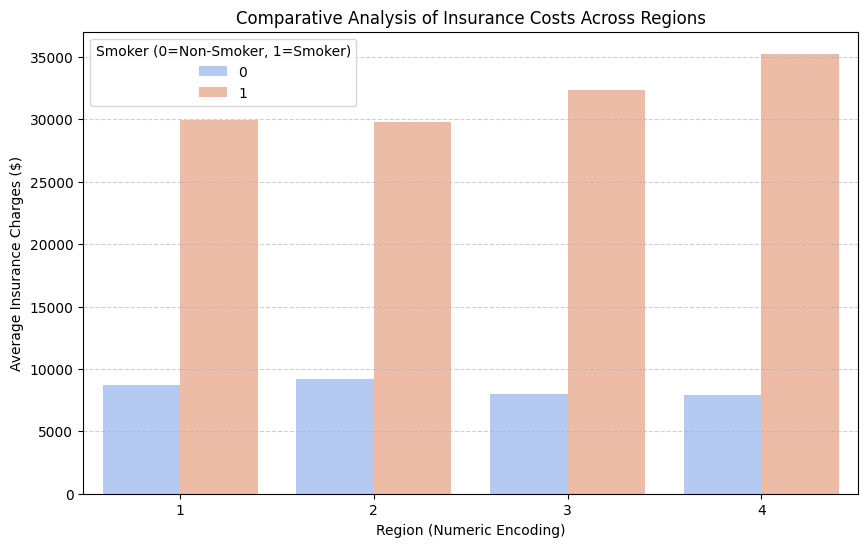

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x="region", y="charges", hue="smoker", data=region_charges, palette="coolwarm")
plt.title("Comparative Analysis of Insurance Costs Across Regions")
plt.xlabel("Region (Numeric Encoding)")
plt.ylabel("Average Insurance Charges ($)")
plt.legend(title="Smoker (0=Non-Smoker, 1=Smoker)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

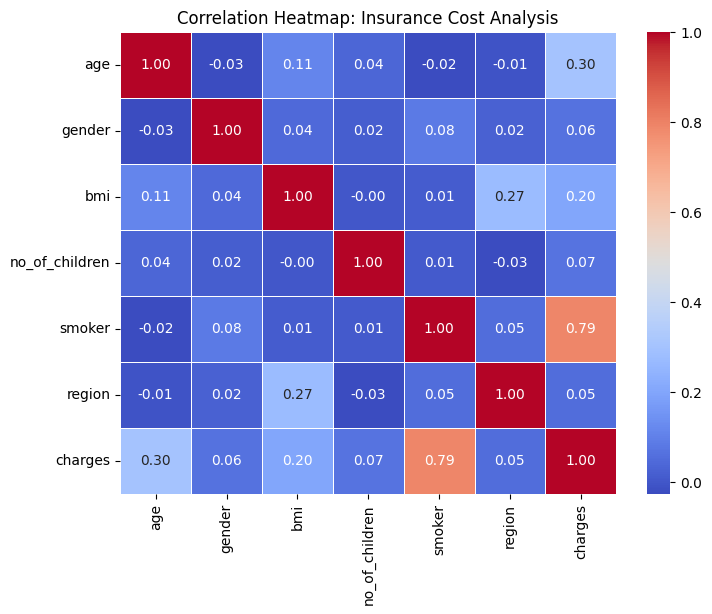

In [10]:
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Insurance Cost Analysis")
plt.show()


In [10]:
for i in df.columns.values.tolist():
    c, p= stats.pearsonr(df[i], df["charges"])
    print(f"{i}:\nCoef:{c.round(4)}\nPvalue:{p}\n")

age:
Coef:0.2986
Pvalue:3.3160850120110425e-58

gender:
Coef:0.0628
Pvalue:0.0009325425283975804

bmi:
Coef:0.1998
Pvalue:2.29351916547895e-26

no_of_children:
Coef:0.0664
Pvalue:0.00046444766841148387

smoker:
Coef:0.7888
Pvalue:0.0

region:
Coef:0.0541
Pvalue:0.004414508249390473

charges:
Coef:1.0
Pvalue:0.0



Text(0.5, 1.0, 'charges with respect to age')

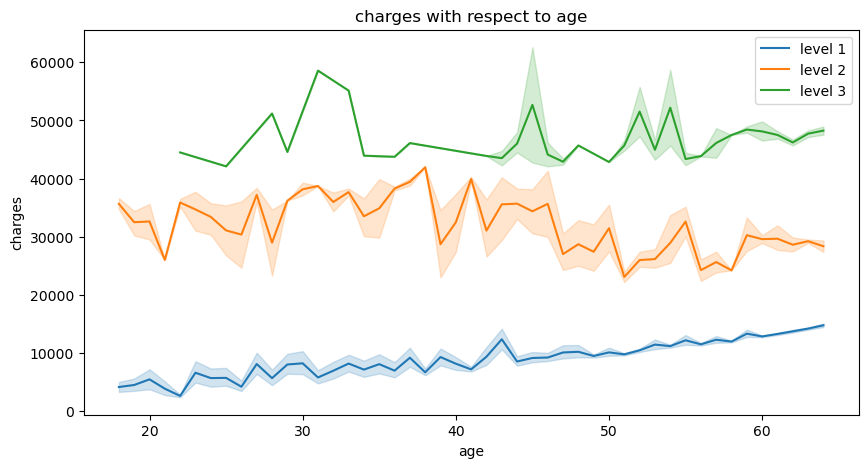

In [53]:
plt.figure(figsize=(10,5))
ax1=sns.lineplot(x=df["age"], y=df["charges"][df["charges"]<22000], label="level 1")
ax2=sns.lineplot(x=df["age"], y=df["charges"][(df["charges"]<42000)&(df["charges"]>=22000)], ax=ax1, label="level 2")
sns.lineplot(x=df["age"], y=df["charges"][df["charges"]>=42000], ax=ax2, label = "level 3")
ax1.legend()
plt.title("charges with respect to age")

Text(0.5, 1.0, 'charges with respect to bmi')

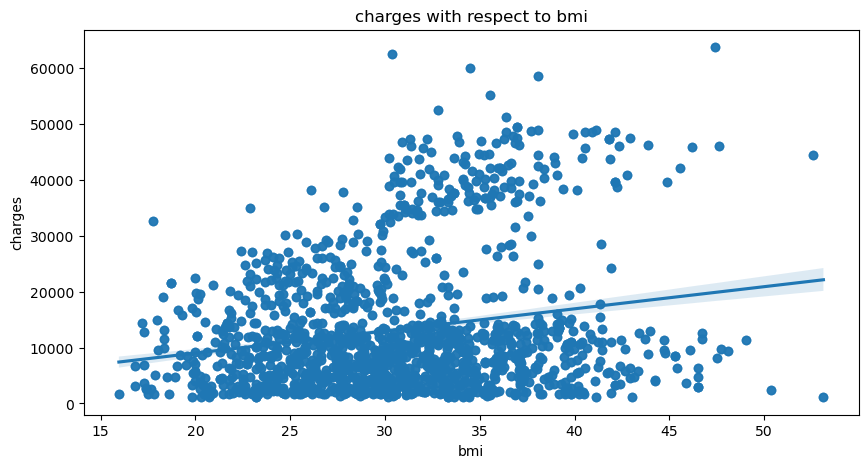

In [51]:
plt.figure(figsize=(10,5))
sns.regplot(x="bmi", y="charges", data=df)
plt.title("charges with respect to bmi")

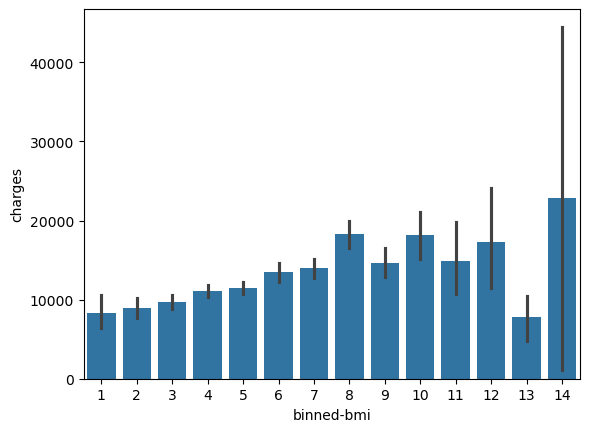

In [75]:
bins = np.linspace(min(df["bmi"]), max(df["bmi"]), 15)
df["binned-bmi"] = pd.cut(df["bmi"], bins=bins, labels=range(1,15), include_lowest=True)
sns.barplot(x=df["binned-bmi"], y=df["charges"])
plt.show()

<Axes: xlabel='smoker', ylabel='charges'>

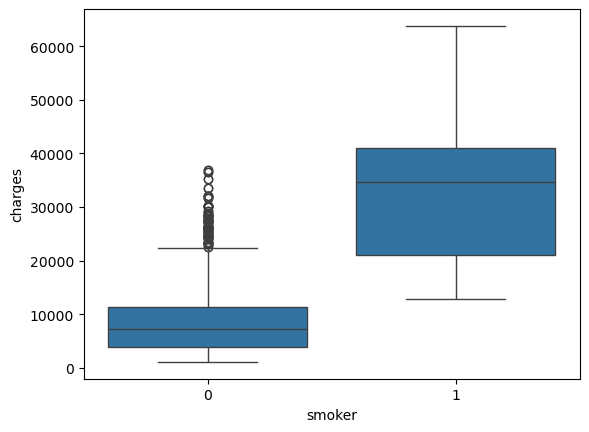

In [77]:
sns.boxplot(x=df["smoker"], y=df["charges"])

<Axes: xlabel='gender', ylabel='charges'>

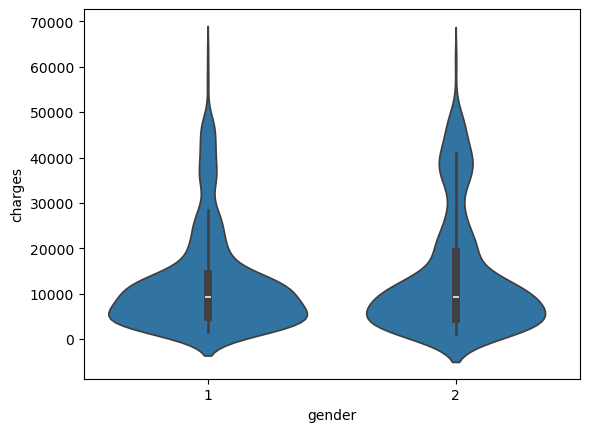

In [81]:
sns.violinplot(x=df["gender"], y=df["charges"])

## Model Development

In [156]:
lr=LinearRegression()
y_data= df["charges"]
x_data= df.drop(["charges", "binned-charges", "binned-bmi"], axis=1)

In [158]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)
lr.fit(x_train[["smoker"]], y_train)
lr.score(x_test[["smoker"]], y_test), lr.score(x_train[["smoker"]], y_train)

(0.6279851995001544, 0.6188163236523186)

In [160]:
lr.fit(x_train, y_train)
lr.score(x_test, y_test), lr.score(x_train, y_train)

(0.7710720409749604, 0.7403170713074028)

<Axes: >

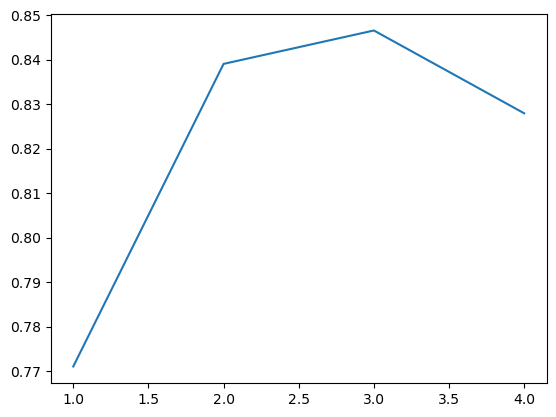

In [166]:
r2 = []
order = [1, 2, 3, 4]

for i in order:
    pr=PolynomialFeatures(degree=i)
    x_train_pr= pr.fit_transform(x_train)
    x_test_pr= pr.fit_transform(x_test)

    lr.fit(x_train_pr, y_train)
    r2.append(lr.score(x_test_pr, y_test))

sns.lineplot(x=order, y=r2)

In [180]:
pr=PolynomialFeatures(degree=3)
x_train_pr= pr.fit_transform(x_train)
x_test_pr= pr.fit_transform(x_test)
lr.fit(x_train_pr, y_train)
yhat=lr.predict(x_test_pr)
print(f"MSE: {mean_squared_error(y_test, yhat)}\n\
RSquared: {lr.score(x_test_pr, y_test)}")

MSE: 23826114.321892757
RSquared: 0.8466094418045195


In [198]:
inp = [("scale", StandardScaler()),("poly", PolynomialFeatures(include_bias=False, degree=3)),("model",LinearRegression())]
pipe = Pipeline(inp)
x_train = x_train.astype("float64")
pipe.fit(x_train, y_train)
yhat_pipe=pipe.predict(x_test)
print(f"MSE: {mean_squared_error(y_test, yhat_pipe)}\n\
RSquared: {pipe.score(x_test, y_test)}")

MSE: 20507599.130828843
RSquared: 0.8679737688055761


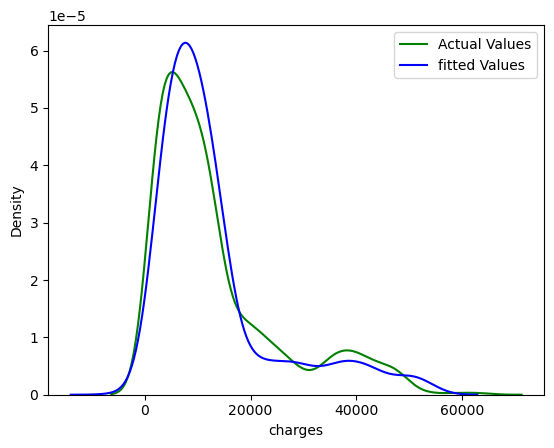

In [208]:
ax1 = sns.kdeplot(y_data, label="Actual Values", color="green")
sns.kdeplot(yhat_pipe, label="fitted Values", color="blue", ax=ax1)
ax1.legend()

In [221]:
alpha = np.arange(0.1, 100, 0.1)
bar = tqdm(alpha)
r2_train = []
r2_test = []

for i in bar:
    RR= Ridge(alpha=i)
    RR.fit(x_train_pr, y_train)
    r2train, r2test = RR.score(x_train_pr, y_train), RR.score(x_test_pr, y_test)
    r2_train.append(r2train)
    r2_test.append(r2test)

    bar.set_postfix({"Train Score":r2train, "Test Score":r2test, "Alpha":i})
    if r2test == max:
        x=i

print(i)



100%|██████████| 999/999 [00:07<00:00, 136.61it/s, Train Score=0.842, Test Score=0.865, Alpha=99.9]

99.9


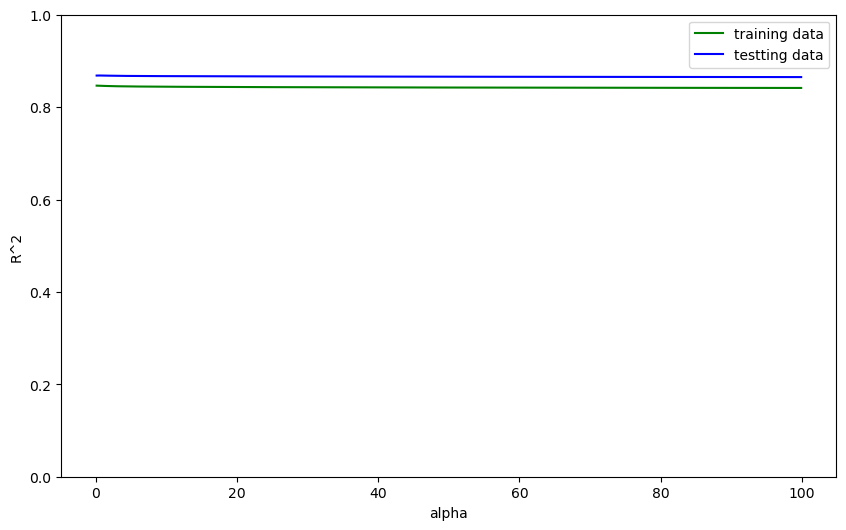

In [223]:
plt.figure(figsize=(10, 6))  

plt.plot(alpha, r2_train, label="training data", color="green")
plt.plot(alpha, r2_test, label="testting data", color="blue")
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0, 1)
plt.legend()